# TCC Augusto e Ícaro
## Clusterização de textos classificados pelo corpus gerado na v0.3.0 do modelo

* Versão 0.3.0
* Bibliotecas utilizadas: pandas, numpy, texthero, ntlk e corpus do ntlk em português
* Dataset utilizado: dataset_v9.csv
* Data: 05-07-2020

### Objetivos, incrementos e correções:

* Encapsulamento da pipeline de pre-processamento
* Utilizando dataset com classificação revisada para melhor acurácia
* Aumento dos pesos de termos classificados como usabilidade
* Foco em detalhar e evoluir o dicionário de radicais classificados

In [2]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install texthero 
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install sklearn

Requirement already up-to-date: pip in /home/icaro/.pyenv/versions/3.7.3/lib/python3.7/site-packages (20.2.1)


In [3]:
import pandas as pd
import texthero as hero
import nltk
from nltk.corpus import stopwords
import numpy as np
# nltk.download()

In [280]:
DROPLIST_FILENAME='droplist.0.2.0.txt'
MODEL_FILENAME='models/model_v0.3.0.json'
DATASET_SENTIMENTS_FILENAME='datasets/reviews_with_sentiments_31-08-2020.csv'
DATASET_CLASSIFIED_FILENAME='datasets/reviews_v9.csv'

In [28]:
def pre_process(df_path, df_cols):
    df = pd.read_csv(df_path, index_col=False, usecols=df_cols)
    try:
        df = df[df['is_classified']==True]
    except: 
        pass
    df = df.rename(columns={'Text': 'text'})
    df['text'] = hero.preprocessing.clean(df['text'])
    pt_stopwords = stopwords.words('portuguese')
    df['text'] = hero.remove_stopwords(df['text'], stopwords=pt_stopwords)
    df['text'] = hero.stem(df['text'], language='portuguese')
    df['text'] = hero.tokenize(df['text'])
    try:
        df['class_name'] = df.apply(lambda row: 'usability' if row['is_usability'] else 'not_usability', axis=1)
        df = df.drop('is_usability', 1)
    except:
        df['class_name'] = pd.Series(dtype='str')
    return df    

In [29]:
def classificate(corpus, sentence):
    def calculate_class_score(corpus_words, sentence, class_name):
        score = 0 
        for word in sentence:
            if word in corpus_words[class_name]:
                score += corpus_words[class_name][word]
        return score
    classifications = []
    for class_name in corpus.keys():
        classifications.append({'class_name': class_name, 'score': calculate_class_score(corpus, sentence, class_name)})    
    return classifications

In [145]:
def normalize_scores(classification):
    total_score = sum(score['score'] for score in classification['scores'])
    if total_score != 0:
        for score in classification['scores']:
            score['score'] = score['score']/total_score
    return classification

In [282]:
def drop_unwanted_words(corpus, droplist):
    filtered_dict = {}
    for k in corpus.keys():
        filtered_dict.update({k: { key:value for (key,value) in corpus[k].items() if key not in droplist }})
    return filtered_dict

In [171]:
df_sentiments = pre_process(DATASET_SENTIMENTS_FILENAME, ['ID', 'Text', 'Sentiment'])
df_heuristics = pre_process(DATASET_CLASSIFIED_FILENAME, ['ID', 'Text', 'is_usability', 'is_classified'])

In [210]:
import json

with open(MODEL_FILENAME) as f:
  corpus = json.load(f)

In [172]:
df_heuristics

,ID,text,is_classified,class_name
0,gp:AOqpTOGQYqUxy0wRIy5v-ZwXfMcNn_nF4FiKbB5rwnp...,[ok],True,not_usability
1,gp:AOqpTOG9KAw8pd1bk9SAiCG427z_uVCb_TJB-ihNXjx...,[hh],True,not_usability
2,gp:AOqpTOEJ-tdSvp09Dvg3_81aTiDuhPPW9RKp5RtmAjc...,[ok],True,not_usability
3,gp:AOqpTOGCAu9M166-MbVWhpmNh8LagaNeva-mS5aY-VQ...,[top],True,not_usability
4,gp:AOqpTOH-TkxBfhnIzr1Jqm9y42DJBdWeYlcbnrXPOhY...,[boa],True,not_usability
...,...,...,...,...
925,gp:AOqpTOGaoRHM_nm5_HTUJ0KGpZhibNWU3yEM2PSPQJw...,"[link, inform, quebr, nao, segur, ja, tent, to...",True,usability
926,gp:AOqpTOFa6Uc8lHM7NUgRXC7UOfyqJ_vu7qCX_PP43lH...,"[dand, estrel, pq, pra, pod, faz, feedback, ve...",True,usability
927,gp:AOqpTOGeoH5Ek6vAxA-Q6eBmZv-wHZvQ6-oD6OvWP2k...,"[nao, funcion, nao, consig, recuper, senh, fal...",True,usability
928,gp:AOqpTOESrJg3FZ1w0rSaWjvug_qBWjv8b2XrLpCqbBX...,"[sit, pessim, tent, mes, tent, entrar, cadastr...",True,usability


In [173]:
df_sentiments

,ID,Sentiment,text,class_name
0,gp:AOqpTOHZ9b0kCWnytlK-YJh44a9E1GSfAeolQXeg0i-...,positive,"[nao, consig, imprim, bolet, faz, enem, inscre...",NaN
1,gp:AOqpTOGwGfpYa5XpPGL68q_P8LR2HAlWkWtGGtRa70F...,negative,"[pessim, voc, pod, facilit, recuperaca, senh, ...",NaN
2,gp:AOqpTOG-7wpB8tAPlaoqyNm2aA4NQHxvJt-skZClHoS...,neutral,"[n, consig, faz, nad, n, cheg, email, pra, mim]",NaN
3,gp:AOqpTOEdwiop-vwzzF1_0nvas56N2zwdpf3fMF9fwOD...,negative,"[app, pessim, nao, cri, cont, erro, temp, tod,...",NaN
4,gp:AOqpTOEQCKKKvGsEmMY4lgcgA2V8JaIK1JT9siidOOo...,negative,"[orivel, app]",NaN
...,...,...,...,...
1330,gp:AOqpTOFN0MQte5XyWSHw-sAkDm4dVhXcKvr_MINUIDP...,positive,[bom],NaN
1331,gp:AOqpTOG-7hZzRYjQ2YWy_e0IJuBs876YWtvXe2mbgCa...,neutral,"[final, patric, digitaliz]",NaN
1332,gp:AOqpTOEkFvC8miL7mlwhIYWrxPANQOEQNs75fEZyq75...,neutral,[lixxxxxxxoooooooo],NaN
1333,gp:AOqpTOGW-qVe3vXmyxMniDA8ozU6hosukg-g8RbzSEc...,neutral,"[nao, funcion]",NaN


In [185]:
merged_dataset = pd.merge(df_sentiments, df_heuristics, on="ID", how='outer')
merged_dataset

,ID,Sentiment,text_x,class_name_x,text_y,is_classified,class_name_y
0,gp:AOqpTOHZ9b0kCWnytlK-YJh44a9E1GSfAeolQXeg0i-...,positive,"[nao, consig, imprim, bolet, faz, enem, inscre...",NaN,"[nao, consig, imprim, bolet, faz, enem, inscre...",True,usability
1,gp:AOqpTOGwGfpYa5XpPGL68q_P8LR2HAlWkWtGGtRa70F...,negative,"[pessim, voc, pod, facilit, recuperaca, senh, ...",NaN,"[pessim, voc, pod, facilit, recuperaca, senh, ...",True,usability
2,gp:AOqpTOG-7wpB8tAPlaoqyNm2aA4NQHxvJt-skZClHoS...,neutral,"[n, consig, faz, nad, n, cheg, email, pra, mim]",NaN,"[n, consig, faz, nad, n, cheg, email, pra, mim]",True,usability
3,gp:AOqpTOEdwiop-vwzzF1_0nvas56N2zwdpf3fMF9fwOD...,negative,"[app, pessim, nao, cri, cont, erro, temp, tod,...",NaN,"[app, pessim, nao, cri, cont, erro, temp, tod,...",True,usability
4,gp:AOqpTOEQCKKKvGsEmMY4lgcgA2V8JaIK1JT9siidOOo...,negative,"[orivel, app]",NaN,"[orivel, app]",True,not_usability
...,...,...,...,...,...,...,...
1330,gp:AOqpTOFN0MQte5XyWSHw-sAkDm4dVhXcKvr_MINUIDP...,positive,[bom],NaN,NaN,NaN,NaN
1331,gp:AOqpTOG-7hZzRYjQ2YWy_e0IJuBs876YWtvXe2mbgCa...,neutral,"[final, patric, digitaliz]",NaN,NaN,NaN,NaN
1332,gp:AOqpTOEkFvC8miL7mlwhIYWrxPANQOEQNs75fEZyq75...,neutral,[lixxxxxxxoooooooo],NaN,NaN,NaN,NaN
1333,gp:AOqpTOGW-qVe3vXmyxMniDA8ozU6hosukg-g8RbzSEc...,neutral,"[nao, funcion]",NaN,NaN,NaN,NaN


In [186]:
merged_dataset = merged_dataset.drop(columns=['text_y', 'class_name_x'])
merged_dataset = merged_dataset.rename(columns={'text_x': 'text', 'ID': 'id', 'Sentiment': 'sentiment', 'class_name_y': 'class_name'})

In [187]:
merged_dataset['is_classified'] = merged_dataset['is_classified'].fillna(value=False)
merged_dataset

,id,sentiment,text,is_classified,class_name
0,gp:AOqpTOHZ9b0kCWnytlK-YJh44a9E1GSfAeolQXeg0i-...,positive,"[nao, consig, imprim, bolet, faz, enem, inscre...",True,usability
1,gp:AOqpTOGwGfpYa5XpPGL68q_P8LR2HAlWkWtGGtRa70F...,negative,"[pessim, voc, pod, facilit, recuperaca, senh, ...",True,usability
2,gp:AOqpTOG-7wpB8tAPlaoqyNm2aA4NQHxvJt-skZClHoS...,neutral,"[n, consig, faz, nad, n, cheg, email, pra, mim]",True,usability
3,gp:AOqpTOEdwiop-vwzzF1_0nvas56N2zwdpf3fMF9fwOD...,negative,"[app, pessim, nao, cri, cont, erro, temp, tod,...",True,usability
4,gp:AOqpTOEQCKKKvGsEmMY4lgcgA2V8JaIK1JT9siidOOo...,negative,"[orivel, app]",True,not_usability
...,...,...,...,...,...
1330,gp:AOqpTOFN0MQte5XyWSHw-sAkDm4dVhXcKvr_MINUIDP...,positive,[bom],False,NaN
1331,gp:AOqpTOG-7hZzRYjQ2YWy_e0IJuBs876YWtvXe2mbgCa...,neutral,"[final, patric, digitaliz]",False,NaN
1332,gp:AOqpTOEkFvC8miL7mlwhIYWrxPANQOEQNs75fEZyq75...,neutral,[lixxxxxxxoooooooo],False,NaN
1333,gp:AOqpTOGW-qVe3vXmyxMniDA8ozU6hosukg-g8RbzSEc...,neutral,"[nao, funcion]",False,NaN


In [189]:
merged_dataset['class_name'] = merged_dataset['class_name'].replace({np.nan:None})

In [190]:
merged_dataset

,id,sentiment,text,is_classified,class_name
0,gp:AOqpTOHZ9b0kCWnytlK-YJh44a9E1GSfAeolQXeg0i-...,positive,"[nao, consig, imprim, bolet, faz, enem, inscre...",True,usability
1,gp:AOqpTOGwGfpYa5XpPGL68q_P8LR2HAlWkWtGGtRa70F...,negative,"[pessim, voc, pod, facilit, recuperaca, senh, ...",True,usability
2,gp:AOqpTOG-7wpB8tAPlaoqyNm2aA4NQHxvJt-skZClHoS...,neutral,"[n, consig, faz, nad, n, cheg, email, pra, mim]",True,usability
3,gp:AOqpTOEdwiop-vwzzF1_0nvas56N2zwdpf3fMF9fwOD...,negative,"[app, pessim, nao, cri, cont, erro, temp, tod,...",True,usability
4,gp:AOqpTOEQCKKKvGsEmMY4lgcgA2V8JaIK1JT9siidOOo...,negative,"[orivel, app]",True,not_usability
...,...,...,...,...,...
1330,gp:AOqpTOFN0MQte5XyWSHw-sAkDm4dVhXcKvr_MINUIDP...,positive,[bom],False,None
1331,gp:AOqpTOG-7hZzRYjQ2YWy_e0IJuBs876YWtvXe2mbgCa...,neutral,"[final, patric, digitaliz]",False,None
1332,gp:AOqpTOEkFvC8miL7mlwhIYWrxPANQOEQNs75fEZyq75...,neutral,[lixxxxxxxoooooooo],False,None
1333,gp:AOqpTOGW-qVe3vXmyxMniDA8ozU6hosukg-g8RbzSEc...,neutral,"[nao, funcion]",False,None


In [191]:
merged_dataset = merged_dataset.to_dict('records')

In [230]:
for data in merged_dataset:
    if not data['is_classified']:
        classifications = {'scores': classificate(corpus, data['text'])}
        classifications = normalize_scores(classifications)
        highest_score = max(classifications['scores'], key=lambda x:x['score'])
        data['class_name'] = highest_score['class_name']

In [241]:
documents = []
for w in merged_dataset:
    if(w['class_name'] == 'usability' and w['sentiment'] in ['negative', 'neutral']):
        documents.append(' '.join(w['text']))
len(documents)

805

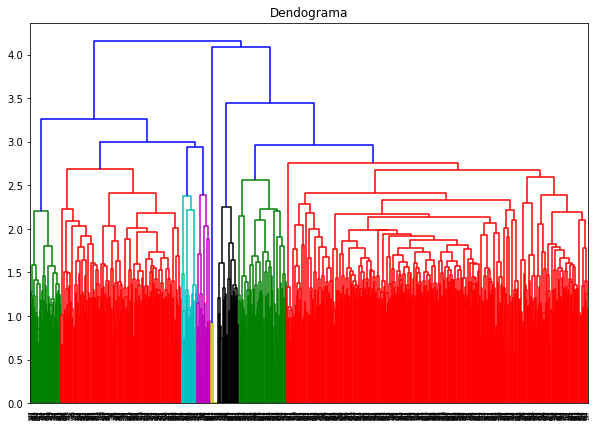

In [335]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

plt.figure(figsize=(10, 7))
plt.title("Dendograma")
dend = dendrogram(linkage(X.toarray(), method='ward'))


In [400]:
n_clusters=5
cluster = AgglomerativeClustering(n_clusters, affinity='euclidean', linkage='ward')
Y = cluster.fit_predict(X.toarray())
centroide = {}
for i in range(n_clusters):
    centroide[i] = {}
    cluster_words_indexes = np.where(Y == i)
    for cw in cluster_words_indexes:
        for w in cw:
            for palavra in documents[w].split():
                if palavra not in list(centroide[i].keys()):
                    centroide[i][palavra] = 1
                else:
                    centroide[i][palavra] += 1
droplist = open(DROPLIST_FILENAME).read().splitlines()
centroide = drop_unwanted_words(centroide, droplist)

def calculate_cluster_score(centroide, sentence, number):
        score = 0 
        for word in sentence:
            if word in centroide[number]:
                score += centroide[number][word]
        return score


scored_sentences = {}
for i in centroide:
    scored_sentences[i] = []
    for sentence in documents:
        score = calculate_cluster_score(centroide, sentence.split(), i)
        scored_sentences[i].append({'score': score, 'text': sentence})

top_5_scores = {}
for k in scored_sentences.keys():
    sort = sorted(scored_sentences[k], key=lambda k: k['score'], reverse=True) 
    top_5_scores[k] = sort[:5]

top_5_texts_appended = {}
for k in top_5_scores.keys():
    sentences = []
    for sentence in top_5_scores[k]:
        sentences.append(sentence['text'])
    top_5_texts_appended[k] = ' '.join(frases)
top_5_texts_appended

{0: 'nao consig acess pagin particip ver tax pagament pois sit diz ja cadastr por senh diz incorret tent refaz cadastr diz q cadastr tent redefin senh nao aparec nenhum opca celul email send assim nao consig tir bolet decepcion situaca descas govern pra ser simpl caus dor cabec aflit pior experienc ja vid app faz cadastr diz cpf ja cadastr opca recuper senh celul celul cadastr nao recuperaca cnh nao funcion resum algu cadastr usand cpf pass mim fac pra acess desfaz cont irregul ja fiz boletim ocorrenc vist clar exist uso indev cpf quer soluca nao mensag pront nao consig jeit nenhum cadastr diz ja cadastr send nunc cadastr precis ter acess pagin particip enem mim ger bolet finaliz inscrica nao nao consig faz enem faq nao prest pra nad recup senh cont men aind diz nao precis cont acess ped ter cont acess precis concert log govern inutil cidada nao consig acompanh inscrica enem pois dificuldad cadastr sit gov br pois moment cadastr diz usuari ja cadastr send nunc fiz cadastr ness sit apar

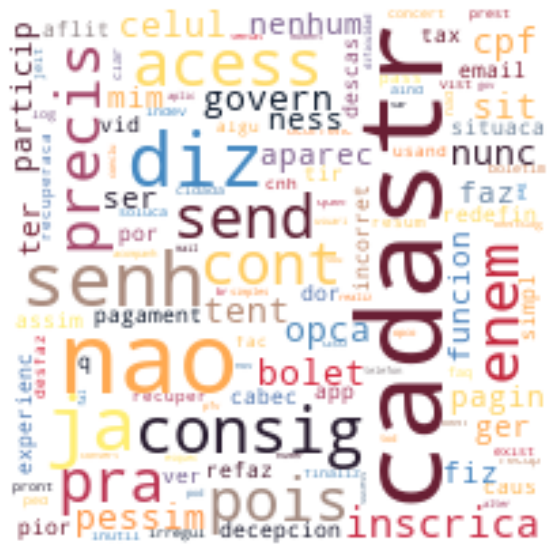

In [398]:
hero.wordcloud(pd.Series(top_5_texts_appended[0]), width=200, height=200, background_color='white')

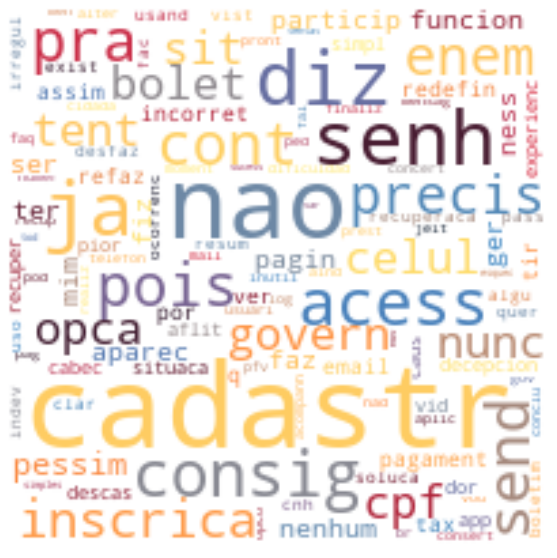

In [399]:
hero.wordcloud(pd.Series(top_5_texts_appended[1]), width=200, height=200, background_color='white')